# Lagged cross-covariance analysis

Resolution: TransCom 3 regions, monthly

---

In [1]:
import sys
sys.path.insert(0, "../src")

In [32]:
import numpy as np
import pandas as pd
import xarray

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

import stats 
import data_utils as utils
import plotting as plot

In [3]:
# Define color map with nans set to grey
# cmap = plt.get_cmap("jet")
# cmap.set_bad("grey")

In [4]:
DS_sif = xarray.open_dataset("../data/exp_pro/OCO2_Lite_SIF740.nc")
DS_xco2 = xarray.open_dataset("../data/exp_pro/OCO2_Lite_XCO2_land.nc")

In [5]:
# Compute the monthly mean in each Transcom region
DS_tc = utils.read_transcom("../data/exp_pro/TRANSCOM_region_mask.nc")

df_sif_tc = (
    utils.map_transcom(DS_sif, DS_tc)
    .groupby(["region"])
    .resample("1MS")
    .mean()
    .drop(columns=["region"])
    .reset_index()
)
df_xco2_tc = (
    utils.map_transcom(DS_xco2, DS_tc)
    .groupby(["region"])
    .resample("1MS")
    .mean()
    .drop(columns=["region"])
    .reset_index()
)

# Merge dataframes
# NOTE: all months present since 71*11 = 781
df_tc_monthly = pd.merge(df_sif_tc, df_xco2_tc, on=["region", "time"], how="outer")
df_tc_monthly

,region,time,sif,xco2
0,1.0,2014-09-01,0.076657,392.668091
1,1.0,2014-10-01,0.033639,394.742004
2,1.0,2014-11-01,0.058322,397.809540
3,1.0,2014-12-01,NaN,399.142395
4,1.0,2015-01-01,0.068451,397.693054
...,...,...,...,...
776,11.0,2020-03-01,0.115146,414.438507
777,11.0,2020-04-01,0.192141,414.435455
778,11.0,2020-05-01,0.356506,413.789368
779,11.0,2020-06-01,0.517523,411.653442


In [35]:
# Groupby region and compute cross-covariance
df_stats = (
    df_tc_monthly
    .drop(columns=["time"])
    .groupby(["region"])
    .apply(lambda group: stats.get_stats_df(group, lags=[1, 2]))
    .reset_index()
    .drop(columns=["level_1"])
 )

df_stats

,region,sif_count,xco2_count,sif_slope,xco2_slope,sif_std,xco2_std,xcor_lag1,xcor_lag2
0,1.0,64,67,0.000134,0.218979,0.064347,3.293066,-0.749392,-0.589449
1,2.0,70,70,0.000503,0.219632,0.142903,2.058822,-0.754244,-0.933807
2,3.0,70,70,-0.000013,0.212009,0.020705,1.060384,-0.535314,-0.321954
3,4.0,70,70,0.000233,0.207012,0.051061,0.639513,-0.238081,0.141877
4,5.0,70,70,0.000082,0.219466,0.035173,1.832536,-0.840124,-0.830455
5,6.0,70,70,0.000268,0.204819,0.087129,0.804401,-0.820224,-0.535951
6,7.0,70,70,0.000697,0.216579,0.119683,3.128884,-0.878564,-0.687347
7,8.0,70,70,0.000330,0.217570,0.041488,2.127945,-0.775230,-0.873034
8,9.0,70,70,0.000432,0.218085,0.087130,1.497082,-0.700187,-0.835887
9,10.0,70,70,-0.000263,0.209854,0.025993,0.441697,-0.510602,-0.145268


In [37]:
# Map values to transcom grid dataset
df_regions = DS_tc.to_dataframe().dropna().reset_index()
DS_regions = (
    df_regions
    .merge(df_stats, on=["region"])
    .set_index(["lon", "lat"])
    .to_xarray()
   )

DS_regions

<xarray.Dataset>
Dimensions:     (lat: 137, lon: 338)
Coordinates:
  * lon         (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat         (lat) float64 -54.5 -53.5 -52.5 -51.5 ... 78.5 79.5 80.5 82.5
Data variables:
    region      (lon, lat) float32 nan nan nan nan nan ... nan nan nan nan nan
    sif_count   (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan
    xco2_count  (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan
    sif_slope   (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan
    xco2_slope  (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan
    sif_std     (lon, lat) float32 nan nan nan nan nan ... nan nan nan nan nan
    xco2_std    (lon, lat) float32 nan nan nan nan nan ... nan nan nan nan nan
    xcor_lag1   (lon, lat) float32 nan nan nan nan nan ... nan nan nan nan nan
    xcor_lag2   (lon, lat) float32 nan nan nan nan nan ... nan nan nan nan nan

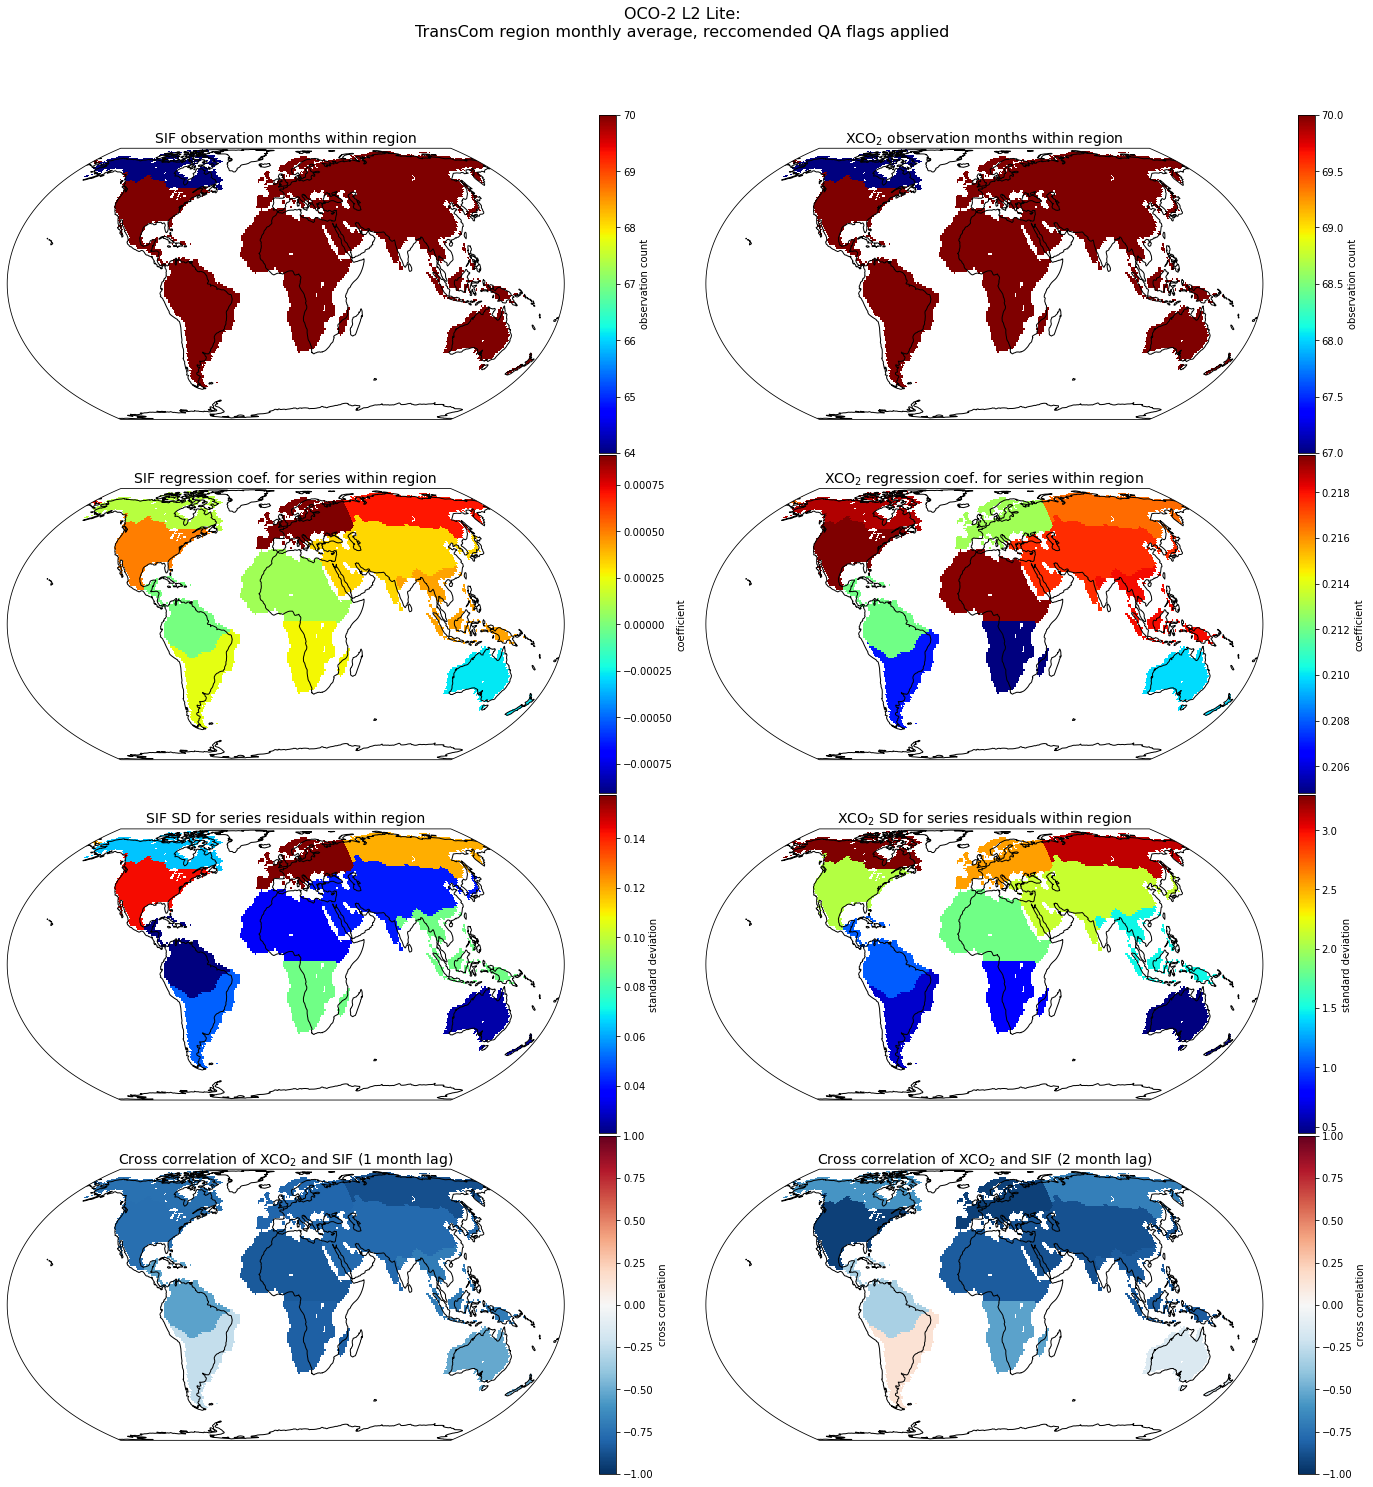

In [38]:
fig = plt.figure(figsize=(25, 25))
gs = fig.add_gridspec(100, 100)

# fig.subplots_adjust(top=0.8)
fig.suptitle(
    "OCO-2 L2 Lite:\n"
    "TransCom region monthly average, reccomended QA flags applied",
    size=16, y=0.94
)

# Counts
ax1 = fig.add_subplot(gs[:25, 0:50], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[:25, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_regions.sif_count,
    title="SIF observation months within region",
    ax=ax1,
    cbar_kwargs={"label": "observation count"}
)
plot.plot_da(
    DS_regions.xco2_count,
    title="XCO$_2$ observation months within region",
    ax=ax2,
    cbar_kwargs={"label": "observation count"}
)

# Slopes
ax3 = fig.add_subplot(gs[25:50, 0:50], projection=ccrs.EqualEarth())
ax4 = fig.add_subplot(gs[25:50, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_regions.sif_slope,
    title="SIF regression coef. for series within region",
    ax=ax3,
    cbar_kwargs={"label": "coefficient"}
)
plot.plot_da(
    DS_regions.xco2_slope,
    title="XCO$_2$ regression coef. for series within region",
    ax=ax4,
    cbar_kwargs={"label": "coefficient"}
)

# Standard deviation
ax5 = fig.add_subplot(gs[50:75, 0:50], projection=ccrs.EqualEarth())
ax6 = fig.add_subplot(gs[50:75, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_regions.sif_std,
    title="SIF SD for series residuals within region",
    ax=ax5,
    cbar_kwargs={"label": "standard deviation"}
)
plot.plot_da(
    DS_regions.xco2_std,
    title="XCO$_2$ SD for series residuals within region",
    ax=ax6,
    cbar_kwargs={"label": "standard deviation"}
)

# Cross correlation
ax7 = fig.add_subplot(gs[75:, 0:50], projection=ccrs.EqualEarth())
ax8 = fig.add_subplot(gs[75:, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_regions.xcor_lag1,
    title="Cross correlation of XCO$_2$ and SIF (1 month lag)",
    ax=ax7,
    vmin=-1, vmax=1,
    cmap="RdBu_r",
    cbar_kwargs={"label": "cross correlation"}
)
plot.plot_da(
    DS_regions.xcor_lag2,
    title="Cross correlation of XCO$_2$ and SIF (2 month lag)",
    ax=ax8,
    vmin=-1, vmax=1,
    cmap="RdBu_r",
    cbar_kwargs={"label": "cross correlation"}
)

fig.savefig("../plots/transcom_monthly_panel.png");